## Cellprofiler demo for Jupyter notebook  - run with kernel CP4 !  (see below)

**WORK IN PROGRESS**

(modifed by A.L. 2020-09-23  from the older https://github.com/CellProfiler/notebooks/blob/master/cellprofiler_demo.ipynb)


### CellProfiler as a Python package

In addition to running CellProfiler’s graphical-or-command-line interface, CellProfiler is usable from any Python environment (e.g. a Python interpreter, Jupyter Notebook, or a Python package).

- https://github.com/CellProfiler/CellProfiler
- https://github.com/CellProfiler/CellProfiler/wiki/Ubuntu-18.04
- https://github.com/CellProfiler/CellProfiler/wiki/Source-installation-%28OS-X-and-macOS%29
- https://github.com/CellProfiler/CellProfiler/wiki/CellProfiler-as-a-Python-package

See also:<br>
- https://github.com/CellProfiler/CellProfiler/wiki/Getting-started-using-CellProfiler-from-the-command-line


### Install CellProfiler 4 as a Python package on MacOS / Ubuntu 18.04

(to install on Windows: see https://github.com/CellProfiler/CellProfiler/wiki/Source-installation-%28Windows%29)

```bash
# First: deactivate the conda environment imc
conda deactivate
# Ubuntu 18.04
sudo apt update
sudo apt upgrade
sudo apt install make gcc build-essential libgtk-3-dev
sudo apt install openjdk-11-jdk-headless default-libmysqlclient-dev libnotify-dev libsdl2-dev
sudo apt install libwebkit2gtk-4.0-dev
# MacOS and Ubuntu:
conda create --name cp4 python=3.8
conda activate cp4
conda install ipykernel
conda install jupyter
python -m ipykernel install --user --name cp4 --display-name "CP4"
conda install git
# Ubuntu 18.04:
pip install -f https://extras.wxpython.org/wxPython4/extras/linux/gtk3/ubuntu-18.04 wxPython==4.1.0
# MacOS (and Windows): cf. https://pypi.org/project/wxPython
pip install wxPython
# MacOS: (you need MySQL - obtained by first installing Homebrew (https://brew.sh), then `brew install`)
brew install mysql
# MacOS: (Install Java JDK14 - Homebrew, again [test with `java --version`]) 
brew install java
# do once: echo 'export PATH="/usr/local/opt/openjdk/bin:$PATH"' >> ~/.zshrc
# do once: echo 'export JAVA_HOME="/usr/local/opt/openjdk/libexec/openjdk.jdk/Contents/Home"' >> ~/.zshrc
# do: source ~/.zshrc
# java --version
# openjdk 14.0.1 2020-04-14
# MacOS and Ubuntu:
pip install pandas
pip install cellprofiler
``` 
-------------------------------

### Quick start - CellProfiler pipelines

#### Setup environment
```
import cellprofiler_core.image
import cellprofiler_core.object
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.workspace
cellprofiler_core.preferences.set_headless()
``` 

#### Open a pipeline
```
pipeline = cellprofiler_core.pipeline.Pipeline()

pipeline.load("example.cppipe")
``` 

#### Create `ImageSetList` and `ImageSet` instances
```
image_set_list = cellprofiler_core.image.ImageSetList()

image_set = image_set_list.get_image_set(0)
``` 

#### Create `Image` instances, name and add them to the `ImageSet` instance
```
import skimage.data
x = skimage.data.camera()

image_x = cellprofiler_core.image.Image(x)

image_set.add("x", image_x)

skimage.io.imshow(image_set.get_image("x").pixel_data)
``` 

#### Create an `ObjectSet` instance, name and add an `Objects` instance

```
object_set = cellprofiler_core.object.ObjectSet()

objects  = cellprofiler_core.object.Objects()

object_set.add_objects(objects, "example")
``` 

#### Create a `Measurements`  instance

```
measurements = cellprofiler_core.measurement.Measurements()
``` 

#### Create a `Workspace` instance
```
workspace = cellprofiler_core.workspace.Workspace(
    pipeline,
    module,
    image_set,
    object_set,
    measurements,
    image_set_list,
)
``` 

#### Run a pipeline
```
output_measurements = pipeline.run(None)
``` 

## Start demo

In [1]:
import cellprofiler

In [2]:
help(cellprofiler)

Help on package cellprofiler:

NAME
    cellprofiler

PACKAGE CONTENTS
    __main__
    gui (package)
    icons (package)
    knime_bridge
    misc
    modules (package)
    utilities (package)

DATA
    __test__ = False

VERSION
    4.0.3

FILE
    /Users/arvid/opt/anaconda3/envs/cp4/lib/python3.8/site-packages/cellprofiler/__init__.py




In [3]:
import os

import cellprofiler_core.image
import cellprofiler_core.measurement
import cellprofiler_core.object
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.workspace
cellprofiler_core.preferences.set_headless()

import numpy as np
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt

In [4]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler_core.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler_core.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler_core.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.items():
        image_set.add(image_name, cellprofiler_core.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler_core.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler_core.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler_core.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace

In [5]:
def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )

In [6]:
# This should match what NamesAndTypes would produce.
images = {
    "OrigBlue": skimage.io.imread("data/images/01_POS002_D.TIF"),
    "OrigGreen": skimage.io.imread("data/images/01_POS002_F.TIF"),
    "OrigRed": skimage.io.imread("data/images/01_POS002_R.TIF")
}

pipeline_filename = "data/ExampleFly.cppipe"

In [7]:
workspace = run_pipeline(pipeline_filename, images)

In [8]:
# Get the "Nuclei" object measurements, as a pandas DataFrame
df = objects2df(workspace.measurements, "Nuclei")
df.head()

,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,...,Texture_SumEntropy_CropBlue_3_02_256,Texture_SumEntropy_CropBlue_3_03_256,Texture_SumVariance_CropBlue_3_00_256,Texture_SumVariance_CropBlue_3_01_256,Texture_SumVariance_CropBlue_3_02_256,Texture_SumVariance_CropBlue_3_03_256,Texture_Variance_CropBlue_3_00_256,Texture_Variance_CropBlue_3_01_256,Texture_Variance_CropBlue_3_02_256,Texture_Variance_CropBlue_3_03_256
1,132.0,198.0,144.0,33.0,126.0,22.0,134.439394,27.234848,1.200659,0.856988,...,4.813051,4.982788,110.835600,75.100779,82.958594,117.061114,44.963900,53.787490,48.574023,48.718767
2,146.0,255.0,96.0,56.0,81.0,39.0,88.116438,46.815068,1.301736,0.860853,...,5.303083,5.291014,209.444336,117.877811,198.054112,211.389900,95.827230,75.862835,100.976399,92.339975
3,165.0,210.0,22.0,73.0,7.0,59.0,14.042424,65.430303,1.037665,0.427925,...,5.096352,4.862913,146.509749,53.875600,111.507708,89.586200,60.166055,40.853900,66.295677,66.384414
4,101.0,168.0,66.0,87.0,54.0,73.0,59.475248,79.643564,1.285003,0.839649,...,4.932620,4.900924,172.553864,80.734843,159.875433,220.632899,90.185076,84.663440,83.615917,83.169763
5,150.0,204.0,81.0,88.0,64.0,76.0,72.006667,81.780000,1.170443,0.783670,...,4.449662,4.188590,39.152047,47.111943,47.344966,27.819235,18.963450,18.025238,17.662974,17.186290


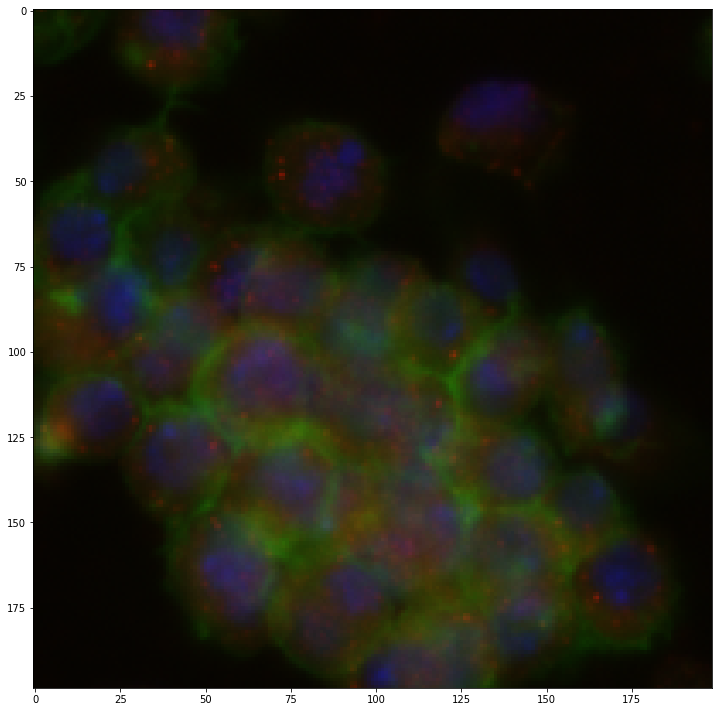

In [9]:
# Display the "RGBImage" image, created by GrayToColor
fig, axes = plt.subplots(1,1, figsize=(10,10))
rgb_image = workspace.image_set.get_image("RGBImage")
skimage.io.imshow(rgb_image.pixel_data)
plt.show()